In [64]:


# import all the tools we need
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

In [2]:
# Function to read annotations from XML files
def read_annot(file_name, xml_dir):
    bbox = []
    labels = []

    annot_path = os.path.join(xml_dir, file_name[:-3] + 'xml')
    if not os.path.exists(annot_path):
        print(f"Annotation file not found: {annot_path}")
        return bbox, labels

    tree = ET.parse(annot_path)
    root = tree.getroot()
    
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        
        # Validate bounding box dimensions
        if xmax > xmin and ymax > ymin:  # Check for valid bounding box
            bbox.append([xmin, ymin, xmax, ymax])
            if label == 'anthracnose':
                    label_idx = 2  # Anthracnose
            elif label == 'healthy':
                    label_idx = 1  # Healthy
            else:
                    label_idx = 0  
            labels.append(label_idx)
        else:
            print(f"Warning: Skipping invalid box {[xmin, ymin, xmax, ymax]} at index due to zero or negative width/height")

    return bbox, labels

# Example of how to read annotations for all images
all_bboxes = []
all_labels = []

In [3]:
# help function for drawing bounding boxes on image
def draw_boxes(img, boxes,labels, thickness=1):
    """
    Function to draw bounding boxes
    Input:
        img: array of img (h, w ,c)
        boxes: list of boxes (int)
        labels: list of labels (int)
    
    """
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 1:
            color = (0,225,0) # green
        elif label == 2:
            color = (0,0,225) # red
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
# Paths and file lists
dir_path_anthracnose = 'D:/Informatika/SKRIPSI/DATASET_PISANG/Antraknosa/images/'
xml_path_anthracnose = 'D:/Informatika/SKRIPSI/DATASET_PISANG/Antraknosa/annotations/'
dir_path_healthy = 'D:/Informatika/SKRIPSI/DATASET_PISANG/Sehat/images/'
xml_path_healthy = 'D:/Informatika/SKRIPSI/DATASET_PISANG/Sehat/annotations/'

file_list_anthracnose = [f for f in os.listdir(dir_path_anthracnose) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
file_list_healthy = [f for f in os.listdir(dir_path_healthy) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Combine lists with corresponding directories
file_list = file_list_anthracnose + file_list_healthy
dir_paths = [dir_path_anthracnose] * len(file_list_anthracnose) + [dir_path_healthy] * len(file_list_healthy)
xml_paths = [xml_path_anthracnose] * len(file_list_anthracnose) + [xml_path_healthy] * len(file_list_healthy)

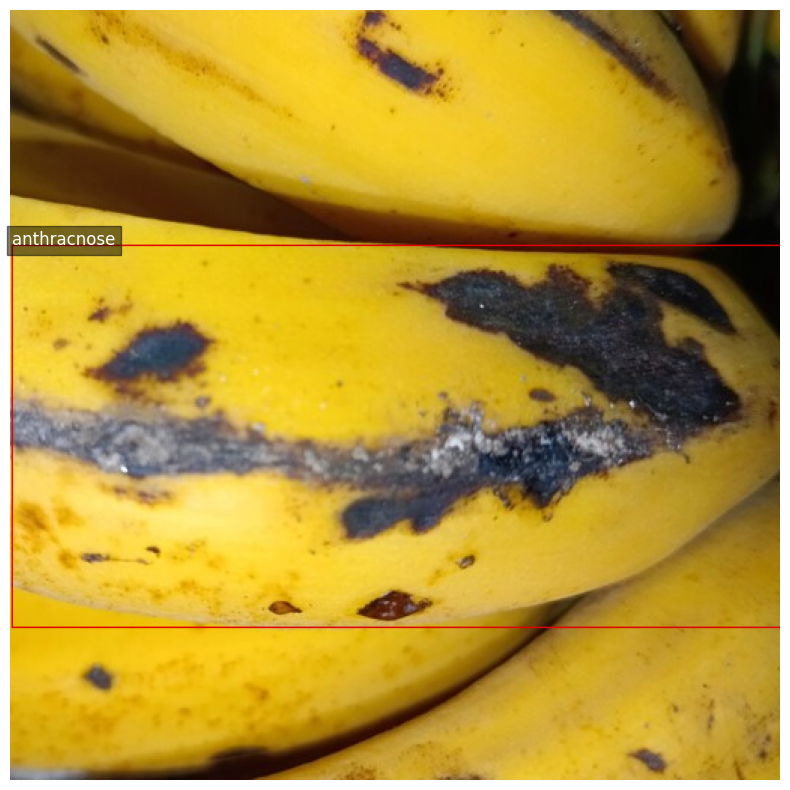

In [5]:
import random
import os
import matplotlib.pyplot as plt
import cv2

# Get the image randomly
image_name = random.choice(file_list)  # Randomly select an image

# Determine the correct XML path based on the image folder
if image_name in file_list_anthracnose:
    xml_path = xml_path_anthracnose
else:
    xml_path = xml_path_healthy

# Get the bbox and label
bbox, labels = read_annot(image_name, xml_path)

# Draw bounding boxes on the image
img = draw_boxes(plt.imread(os.path.join(dir_path_anthracnose if image_name in file_list_anthracnose else dir_path_healthy, image_name)), bbox, labels)

# Display the image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.axis('off')
ax.imshow(img)

# Loop through the bounding boxes and labels to add text
for box, label in zip(bbox, labels):
    # Assuming box is in the format [x_min, y_min, x_max, y_max]
    x_min, y_min, x_max, y_max = box
    # Map label index back to string for display
    label_text = 'healthy' if label == 1 else 'anthracnose'
    ax.text(x_min, y_min, label_text, color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

plt.show()


In [6]:
class BananaDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, dir_paths, xml_paths, transforms=None):
        self.file_list = file_list
        self.dir_paths = dir_paths
        self.xml_paths = xml_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir_paths[idx], self.file_list[idx])
        
        # Read annotations using the read_annot function
        bbox, labels = read_annot(self.file_list[idx], self.xml_paths[idx])

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Check if bbox and labels are not empty
        if not bbox or not labels:
            print(f"Warning: No valid boxes or labels found for index {idx}. Returning empty target.")
            boxes = torch.empty((0, 4), dtype=torch.float32)  # Empty boxes tensor
            labels = torch.empty((0,), dtype=torch.int64)     # Empty labels tensor
        else:
            # Convert everything into a torch tensor
            boxes = torch.as_tensor(bbox, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        # Target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        # Apply transforms if available
        if self.transforms:
            img = self.transforms(img)

        return img, target

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [61]:
# Initialize dataset and data loader
dataset = BananaDataset(file_list, dir_paths, xml_paths, transforms=torchvision.transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)


In [67]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights

In [86]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1)

In [87]:
# Modify the model for binary classification (Anthracnose vs Healthy)
num_classes = 3  # background and Anthracnose
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [88]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [73]:
# Setting the optimizer, lr_scheduler, epochs

params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.001,momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs=5

In [74]:
def forward_train(model, data, device):
    imgs, targets = data
    imgs = [image.to(device) for image in imgs]
    targets = [{k: v.to(device) for k, v in tgt.items()} for tgt in targets]
    
    loss_dict = model(imgs, targets) 
    losses = sum(loss for loss in loss_dict.values())
    
    return losses

In [75]:

from tqdm import tqdm
from IPython.display import clear_output

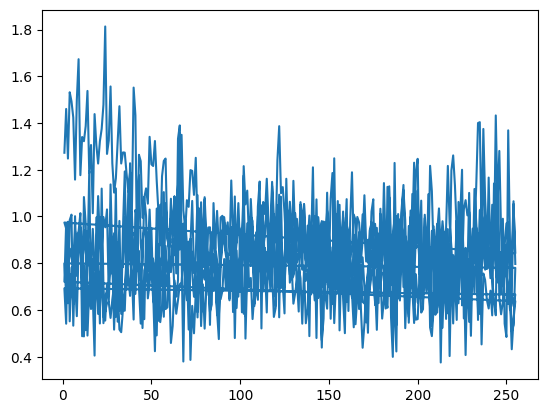

batch loss: 0.7968465685844421, average loss: 0.8371180842904483.: 100%|██████████| 5/5 [07:44<00:00, 92.83s/it]


Training complete.


In [77]:
progress_bar = tqdm(range(5))
loss_log = []
iterations = []

# Training loop
for epoch in progress_bar:
    model.train()
    i = 0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward  pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        i += 1
        loss_log.append(losses.item())
        iterations.append(i)
        progress_bar.set_description(f'batch loss: {losses.item()}, average loss: {np.mean(loss_log)}.')
    
        clear_output(True)
        plt.plot(iterations, loss_log)
        plt.show()

print("Training complete.")
torch.save(model.state_dict(), "fasterrcnn_anthracnose_detector13.pth")

In [84]:
#Function to draw bounding boxes and labels on the image
def draw_boxess(image, boxes, labels):
    # Convert the image to numpy array (assuming image is a PIL Image)
    image = np.array(image)

    # Check if the image is in the right format
    if image.ndim == 3 and image.shape[2] == 3:  # Check if image has 3 channels
        # Draw the rectangles and labels
        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            # Draw the rectangle on the image
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)  # Green box
            # Put the label text above the bounding box
            cv2.putText(image, f'{"Healthy" if label == 0 else "Anthracnose"}', 
                        (int(xmin), int(ymin) - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

# Function for single image prediction
def single_img_predict(img, nm_thrs=0.3, score_thrs=0.6):
    test_img = transforms.ToTensor()(img).unsqueeze(0)  # Convert image to tensor and add batch dimension
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.to(device))

    # Non-max suppression to eliminate overlapping boxes
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'], predictions[0]['scores'], nm_thrs)
    
    # Filter boxes based on score threshold
    score_filter = predictions[0]['scores'][keep_boxes] > score_thrs
    filtered_boxes = predictions[0]['boxes'][keep_boxes][score_filter]
    filtered_labels = predictions[0]['labels'][keep_boxes][score_filter]

    return img, filtered_boxes.cpu().numpy(), filtered_labels.cpu().numpy()

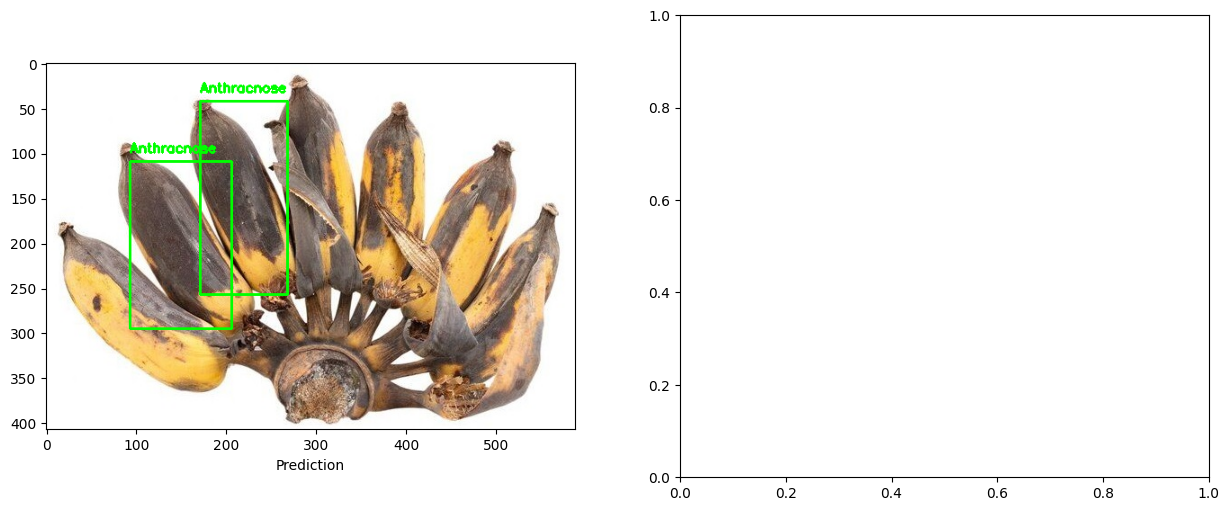

In [85]:

    
test_img = Image.open('D:\Informatika\SKRIPSI\DATASET_PISANG/pisang-busuk-sebagian-apakan-ama-20230328103310.jpg')

# Prediction
test_img, test_boxes, test_labels = single_img_predict(test_img)
test_output = draw_boxess(test_img, test_boxes,test_labels)

# Display the result
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.imshow(test_output)
ax1.set_xlabel('Prediction')
plt.show()

In [18]:
# labels = ['anthracnose', 'healthy']
# label2targets = {l: t for t, l in enumerate(labels)}
# targets2label = {t: l for l, t in label2targets.items()}
# num_classes = len(targets2label)

In [19]:


# from torchvision.ops import nms

# def decode_output(output):
#     bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
#     labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
#     confs = output['scores'].cpu().detach().numpy()
#     idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
#     bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
#     if len(idxs) == 1:
#         bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
#     return bbs.tolist(), confs.tolist(), labels.tolist()




In [20]:
# # helper function for single image prediction
# def single_img_predict(img, nm_thrs = 0.2, score_thrs=0.6):
#     test_img = transforms.ToTensor()(img)
#     model.eval()
    
#     with torch.no_grad():
#         predictions = model(test_img.unsqueeze(0).to(device))
        
#     test_img = test_img.permute(1,2,0).numpy()
    
#     # non-max supression
#     keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
#     # Only display the bounding boxes which higher than the threshold
#     score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
#     # get the filtered result
#     test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
#     test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
#     return test_img, test_boxes, test_labels